In [1]:
from pathlib import Path

import ResNet
from ResNetData import ResNetDataPreprocessor, ResNetDataset
from ResNetTrain import *

import torch

from torch.utils.data import DataLoader
from torchvision import transforms

from torchvision.models import resnet34, ResNet34_Weights

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

import matplotlib.pyplot as plt
import os


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

DATASET_PATH = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/mandatory1_data/')
BASE_PATH = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/')

print("Fetching data.")
preprocessor = ResNetDataPreprocessor(dataset_path=DATASET_PATH, base_path=BASE_PATH)

layers_to_analyse = [3, 15, 34]


Fetching data.
Success! Train, validation and test sets are disjoint.


In [3]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.eval()

for name, module in model.named_children():
    print(name)



conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [4]:
layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']
feature_maps = {}

def hook_function(module, input, output, layer_name):
    feature_maps[layer_name] = output.detach().cpu()

hooks = []
for name in layer_names:
    layer = dict(model.named_children())[name]  # finding the right layer in the model
    hook = layer.register_forward_hook(lambda module, input, output, name=name: hook_function(module, input, output, name))
    hooks.append(hook)

In [5]:
# defining transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet needs 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# getting tha dataset from our existing code
test_dataset = ResNetDataset(preprocessor.annotations_file, BASE_PATH, split="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # using batch_size=1 for single images

# getting feature maps from some images
num_images = 10  # choosing the amount of images to analyse 
model.eval()

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        #image = image.to(device)  # if we have GPU, move the image there
        model(image)  # a forward pass will activate the
        
        print(f"Feature maps stored for image {i+1}")
        
        if i+1 >= num_images:
            break


Feature maps stored for image 1
Feature maps stored for image 2
Feature maps stored for image 3
Feature maps stored for image 4
Feature maps stored for image 5
Feature maps stored for image 6
Feature maps stored for image 7
Feature maps stored for image 8
Feature maps stored for image 9
Feature maps stored for image 10


In [6]:
# Opprett mappe for å lagre feature maps
save_dir = "feature_maps"
os.makedirs(save_dir, exist_ok=True)

# Hent første batch med bilder
batch_size = 10
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hent 10 bilder fra DataLoader
images, labels = next(iter(test_loader))
#images = images.to(device)  # Flytt bilder til GPU hvis tilgjengelig


In [7]:
model.eval()
with torch.no_grad():
    model(images)  # Forward-pass aktiverer hookene

In [8]:
def plot_feature_maps(feature_map, layer_name, image_idx, save_dir, num_filters=6):

    feature_map = feature_map.squeeze(0)  # remove the batch dimension
    num_channels = feature_map.shape[0]   # number of feature maps

    # creating a folder for each image
    image_dir = os.path.join(save_dir, f"image_{image_idx}")
    os.makedirs(image_dir, exist_ok=True)

    for i in range(min(num_filters, num_channels)):
        plt.figure(figsize=(3, 3))
        plt.imshow(feature_map[i].numpy(), cmap="viridis")
        plt.axis("off")
        plt.title(f"{layer_name} - Filter {i}")

        # saving PNG
        save_path = os.path.join(image_dir, f"{layer_name}_filter_{i}.png")
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()  # closing up and freeing up memory

# generating feature maps
for img_idx in range(batch_size):
    for layer_name, feature_map in feature_maps.items():
        plot_feature_maps(feature_map[img_idx].cpu(), layer_name, img_idx, save_dir)


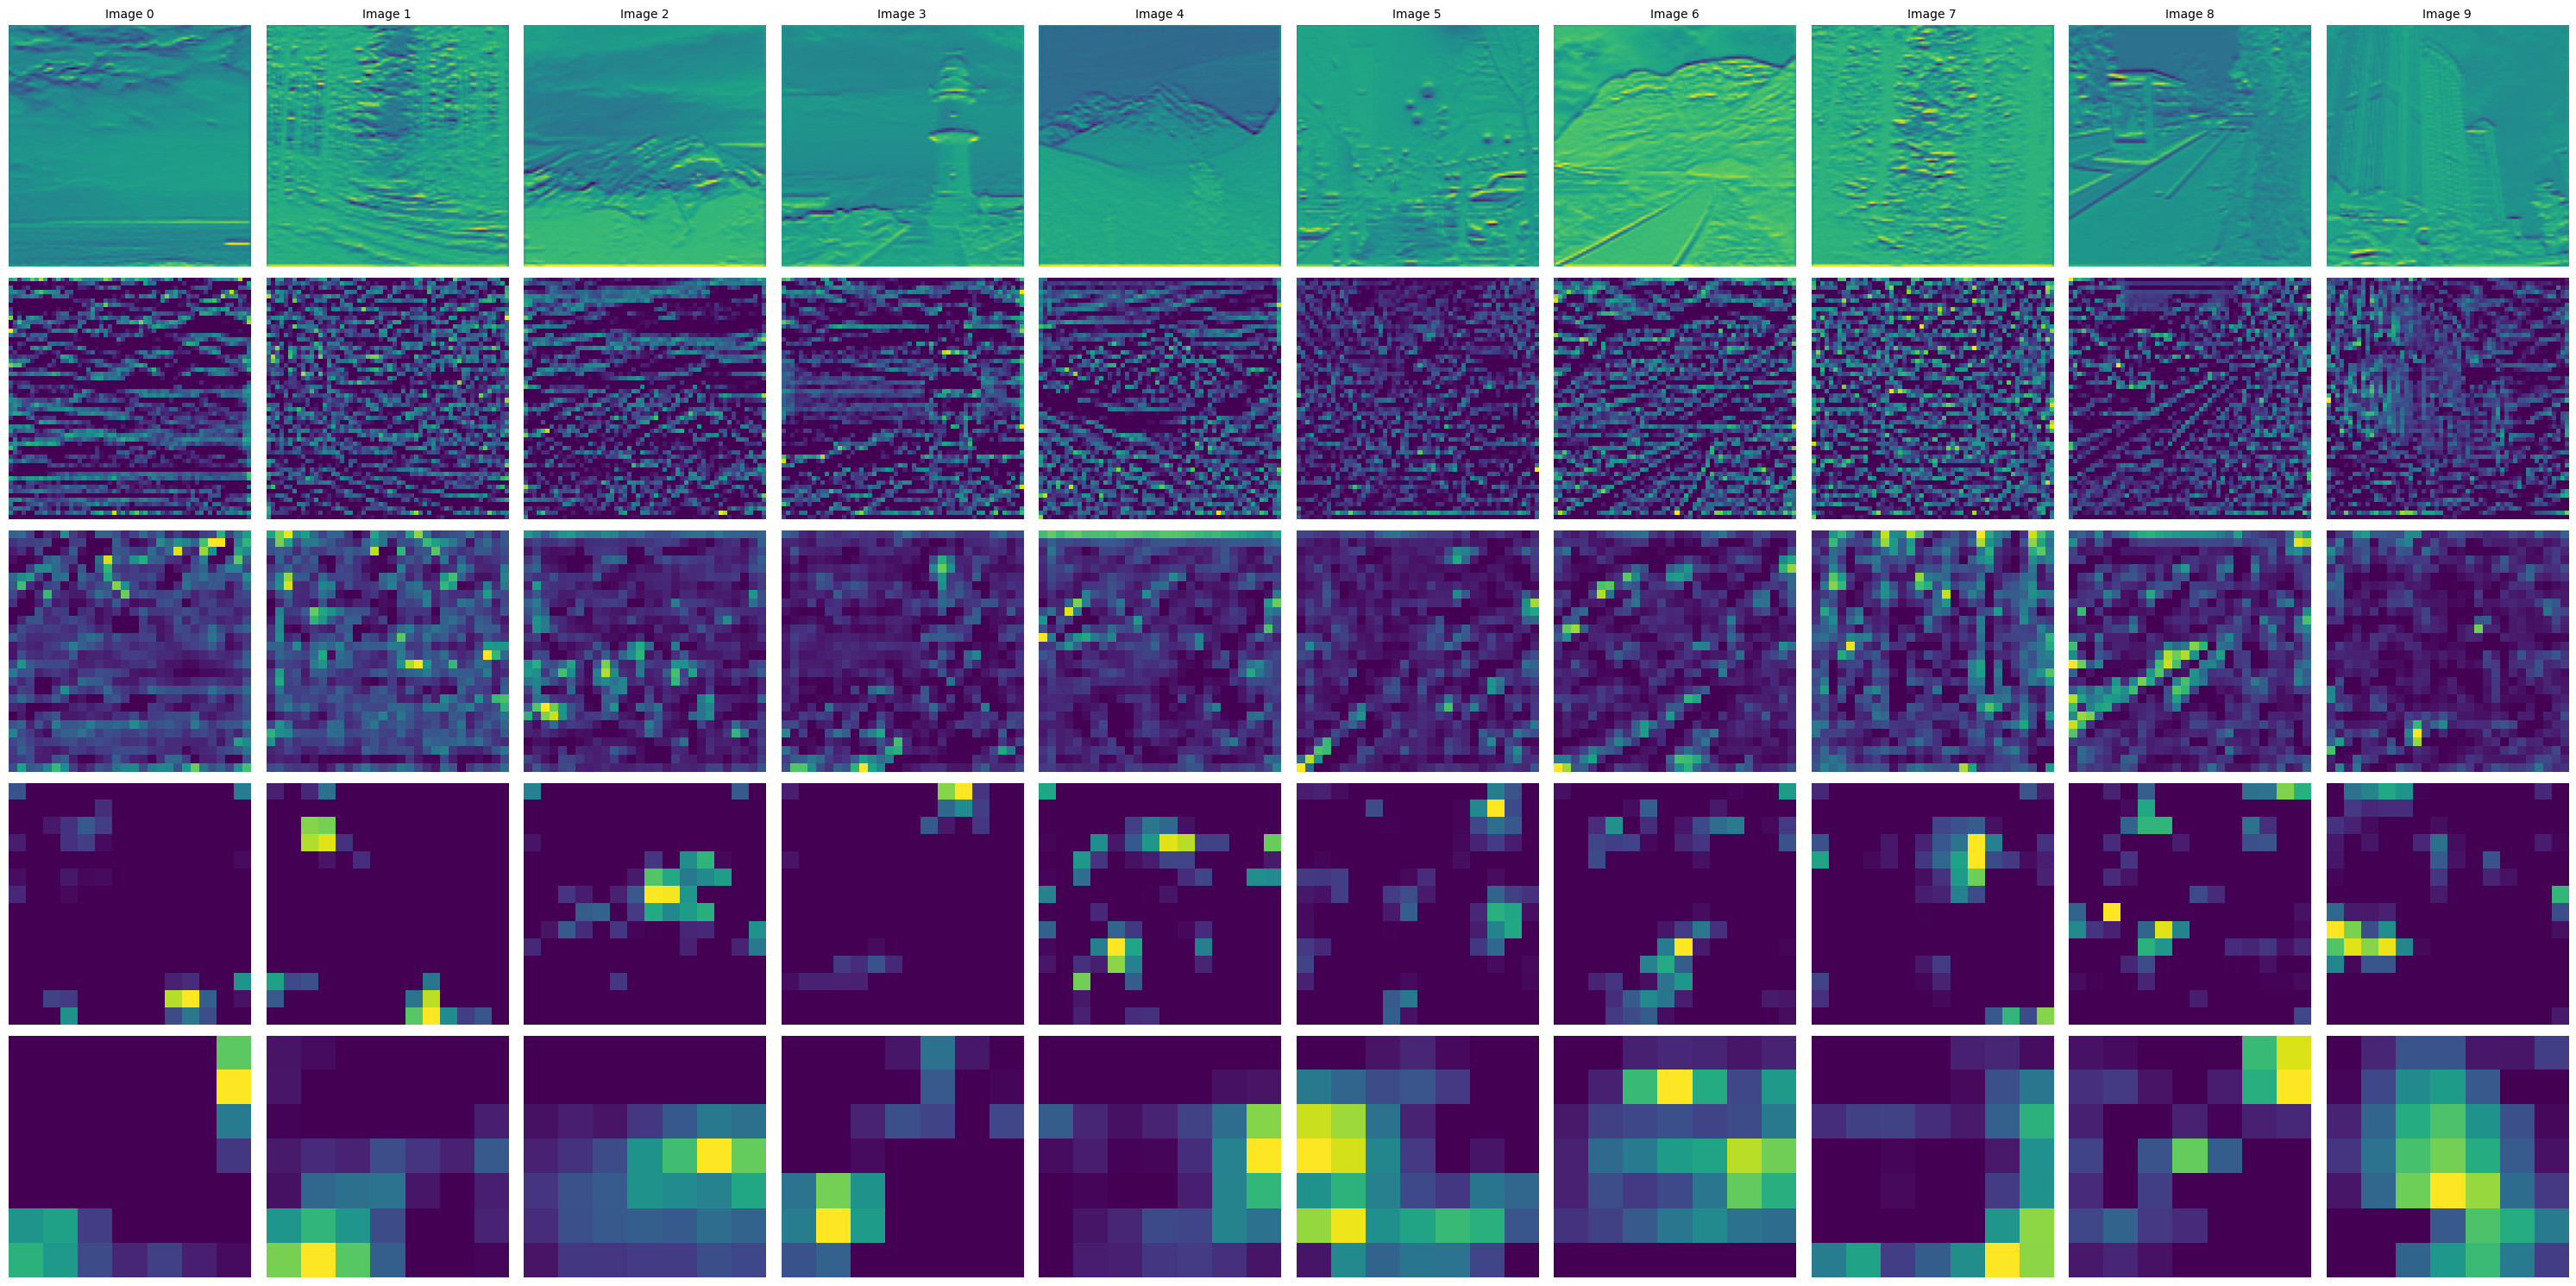

In [9]:
def plot_feature_maps_grid(feature_maps, image_idx_list, layer_names, num_filters=5):
    """
    Plot feature maps som et grid:
    - Rader = forskjellige lag (f.eks. conv1, layer2, layer4)
    - Kolonner = forskjellige bilder (f.eks. image_0, image_1, image_2)
    """
    
    num_images = len(image_idx_list)
    num_layers = len(layer_names)

    fig, axes = plt.subplots(num_layers, num_images, figsize=(num_images * 3, num_layers * 3))

    for row, layer_name in enumerate(layer_names):
        feature_map = feature_maps[layer_name]

        for col, img_idx in enumerate(image_idx_list):
            ax = axes[row, col] if num_layers > 1 else axes[col]  # handle one column
            fm = feature_map[img_idx]  # choose feature maps for this image

            # choose filter
            selected_filter = fm[0].cpu().numpy()  # first filter

            ax.imshow(selected_filter, cmap="viridis")
            ax.axis("off")

            # Legg til labels for første rad og første kolonne
            if row == 0:
                ax.set_title(f"Image {img_idx}", fontsize=10)
            if col == 0:
                ax.set_ylabel(layer_name, fontsize=12)

    plt.tight_layout()
    plt.show()

# Eksempelbruk
image_idx_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Plott fire bilder
layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']  # Lagene vi ser på
plot_feature_maps_grid(feature_maps, image_idx_list, layer_names)
